### IMPORTS AND SETUP

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
import geopandas as gpd
import shapely.wkt
import os, warnings
import logging
import shap
import math

logging.basicConfig(filename='warnings.log', level=logging.DEBUG)

def custom_warning_handler(message, category, filename, lineno, file=None, line=None):
    logging.debug(f'{category.__name__}: {message} in {filename}:{lineno}')

warnings.showwarning = custom_warning_handler

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely.ops import nearest_points
import rioxarray as rxr
import rasterio

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.cluster import DBSCAN
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.base import clone
from joblib import dump

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import sys

print("Python executable:", sys.executable)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SHOW_PLOTS = True  # if you want to display some bar charts, etc.

C:\workspace\python\ai-challenge-2025\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python executable: C:\workspace\python\ai-challenge-2025\.venv\Scripts\python.exe


### FEATURE TOGGLES

In [2]:
FEATURE_FLAGS = {
    # building coverage
    "building_cov_50m":  False,
    "building_cov_100m": True,
    "building_cov_200m": False,
    "building_cov_500m": True,

    # distance to water and parks
    "distance_water": True,
    "distance_parks": True,

    # street tree coverage
    "street_tree_cov_500m": True,

    # distance to subway
    "dist_to_closest_subway_station":   True,
    "dist_to_closest_cluster_centroid": True,
    "building_cluster_id":              True,

    # data fram MapPLUTO
    "map_pluto_data": True,

    # raster-based features
    "lst_value":   True,
    "ndvi_value":  True,
    "ndbi_value":  True,
    "ndwi_value":  True,
    "evi_value":   True,
    "mndwi_value": True,
}

In [3]:
# Define the list of PLUTO columns you wish to extract.
pluto_columns = [
    "NumFloors", "NumBldgs", "UnitsRes", "UnitsTotal", 
    "LotArea", "BldgArea", "ComArea", "ResArea", "FactryArea",
    "AssessLand", "AssessTot", "ExemptTot",
    "BuiltFAR", "ResidFAR", "CommFAR", "FacilFAR",
    "YearBuilt", #"YearAlter1", "YearAlter2", "SPDist1"
    "Borough", "ZoneDist1", "Overlay1", "LandUse", "BldgClass"
]

col_types = {
    "NumFloors": "numerical",
    "LotArea": "numerical",
    "BuiltFAR": "numerical",
    "YearBuilt": "numerical",
    "Borough": "categorical",
    "NumBldgs": "numerical",
    "UnitsRes": "numerical",
    "UnitsTotal": "numerical",
    "BldgArea": "numerical",
    "ComArea": "numerical",
    "ResArea": "numerical",
    "FactryArea": "numerical",
    "AssessLand": "numerical",
    "AssessTot": "numerical",
    "ExemptTot": "numerical",
    "ResidFAR": "numerical",
    "CommFAR": "numerical",
    "FacilFAR": "numerical",
    "YearAlter1": "numerical",
    "YearAlter2": "numerical",
    "ZoneDist1": "categorical",
    "SPDist1": "categorical",
    "Overlay1": "categorical",
    "LandUse": "categorical",
    "BldgClass": "categorical",
}

# Automatically divide the active columns based on the mapping
num_cols = [col for col in pluto_columns if col_types.get(col) == "numerical"]
cat_cols = [col for col in pluto_columns if col_types.get(col) == "categorical"]

# # Optionally add additional categorical columns
# if "building_cluster_id" not in cat_cols:
#     cat_cols.insert(0, "building_cluster_id")

# Now num_cols and cat_cols are created dynamically
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['NumFloors', 'NumBldgs', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'FactryArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt']
Categorical Columns: ['Borough', 'ZoneDist1', 'Overlay1', 'LandUse', 'BldgClass']


### HELPER FUNCTIONS

In [4]:
def coverage_fraction(geom, polygon_gdf, radius=50):
    """
    coverage_fraction:
      - We do buffer around 'geom' by 'radius'.
      - Clip polygon_gdf with that buffer.
      - Sum area of clipped polygons / area of buffer => coverage fraction.
    """
    buffer_poly = geom.buffer(radius)
    clipped = gpd.clip(polygon_gdf, buffer_poly)
    area_polygons = clipped.geometry.area.sum()
    area_buffer = buffer_poly.area
    return area_polygons / area_buffer if area_buffer > 0 else 0


def building_coverage_fraction(geom, building_gdf, radius=50):
    """Simple wrapper specifically for building footprints coverage."""
    return coverage_fraction(geom, building_gdf, radius)


def distance_to_polygons(geom, poly_gdf):
    dists = poly_gdf.geometry.distance(geom)
    return dists.min() if len(dists) > 0 else np.nan


def extract_raster_value(geom, raster, band_index=1, method="nearest"):
    """Return the pixel value from raster at geom's location."""
    x, y = geom.x, geom.y
    val = raster.sel(x=x, y=y, band=band_index, method=method).values
    return float(val)

def find_nearest_building_cluster(pt_geom, gdf_bldg):
    """
    For a given point, find the nearest building (by centroid),
    and return the building's 'bldg_cluster' integer label.
    If no buildings found => returns None.
    """
    distances = gdf_bldg["centroid"].distance(pt_geom)
    if len(distances) == 0:
        return None
    idx_min = distances.idxmin()
    return gdf_bldg.loc[idx_min, "bldg_cluster"]

def nearest_cluster_centroid_label(pt_geom, cluster_centroids):
    """
    For a geometry 'pt_geom', find which cluster centroid
    in 'cluster_centroids' is closest (Euclidian distance),
    and return that cluster label.
    
    cluster_centroids: list of (cluster_label, (cx, cy))
    """
    px, py = pt_geom.x, pt_geom.y
    best_label = None
    best_dist = float("inf")
    for (c_label, (cx, cy)) in cluster_centroids:
        dist_ = math.hypot(cx - px, cy - py)
        if dist_ < best_dist:
            best_dist = dist_
            best_label = c_label
    return best_label

def euclidean_distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)

def run_dbscan_on_buildings(gdf_buildings, eps_m=400, min_samples=10, N_LARGEST=3):
    """
    Run DBSCAN on gdf_buildings (already in EPSG:2263), 
    pick top N_LARGEST clusters by size, compute centroids.
    
    Returns:
      gdf_buildings (modified with new columns):
        - 'bldg_cluster': DBSCAN integer labels
      cluster_centroids: list of (cluster_label, (cx, cy))
      top_clusters: array of the top N_LARGEST labels
    """
    # Create 'centroid' column if not present
    if "centroid" not in gdf_buildings.columns:
        gdf_buildings["centroid"] = gdf_buildings.geometry.centroid
    
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    
    # DBSCAN
    db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords_bldg)
    labels_bldg = db.labels_
    gdf_buildings["bldg_cluster"] = labels_bldg
    
    # Identify valid clusters (ignore noise = -1)
    valid_mask = (labels_bldg >= 0)
    unique_labels, counts = np.unique(labels_bldg[valid_mask], return_counts=True)
    
    # Sort cluster labels by descending size
    sorted_idx = np.argsort(-counts)  # negative for descending
    sorted_labels = unique_labels[sorted_idx]  # e.g. [0,2,1,3,4,...]
    sorted_counts = counts[sorted_idx]
    
    # pick top N_LARGEST
    top_clusters = sorted_labels[:N_LARGEST]
    
    # compute centroids for top clusters
    cluster_centroids = []
    for clabel in top_clusters:
        cl_mask = (gdf_buildings["bldg_cluster"] == clabel)
        cluster_coords = coords_bldg[cl_mask]
        if len(cluster_coords) > 0:
            mp = MultiPoint(cluster_coords)
            c_centroid = mp.centroid
            cluster_centroids.append((clabel, (c_centroid.x, c_centroid.y)))
    
    return gdf_buildings, cluster_centroids, top_clusters

def dist_to_closest_cluster_centroid_feature(geom, cluster_centroids):
    """
    For each geometry, compute distance to the nearest centroid
    among the top N largest clusters.
    cluster_centroids: list of (label, (cx, cy)) only for top clusters
    """
    px, py = geom.x, geom.y
    dmin = float("inf")
    for (lbl, (cx, cy)) in cluster_centroids:
        d = euclidean_distance(px, py, cx, cy)
        if d < dmin:
            dmin = d
    return dmin

def get_pluto_features(geom, gdf, pluto_columns, initial_buffer=1.0, max_buffer=256.0):
    """
    For a given point geometry, first try to find a polygon in 'gdf' (e.g. your enriched gdf_buildings)
    that contains the point. If none is found, gradually increase the buffer (doubling each time)
    until a candidate is found or until max_buffer is reached.
    
    Parameters:
      - geom: a shapely geometry (typically a Point).
      - gdf: a GeoDataFrame with the PLUTO (or enriched) features.
      - pluto_columns: list of column names to extract.
      - initial_buffer: starting buffer distance in the CRS units (e.g., meters).
      - max_buffer: maximum buffer distance to try.
    
    Returns:
      A dictionary mapping each column in pluto_columns to its value in the found polygon;
      if no polygon is found, returns a dictionary with np.nan for each column.
    """
    # First try an exact "within" query (no buffer)
    candidate_idx = list(gdf.sindex.query(geom, predicate="within"))
    
    buffer_distance = initial_buffer
    # If no candidate is found, gradually increase the search area.
    while not candidate_idx and buffer_distance <= max_buffer:
        # Use a buffer around the point and look for intersections.
        candidate_idx = list(gdf.sindex.query(geom.buffer(buffer_distance), predicate="intersects"))
        buffer_distance *= 2  # Double the buffer and try again.
    
    if not candidate_idx:
        print(f"Candidate not found for {geom}")
        # If still nothing is found, return NaNs for all the requested columns.
        return {col: np.nan for col in pluto_columns}
    
    # If multiple candidates are found, select the first candidate.
    best_match = gdf.iloc[candidate_idx[0]]
    return best_match[pluto_columns].to_dict()

def aggregate_pluto_numerics_in_radius(geom, pluto_gdf, numeric_cols, radius=500):
    """
    For each numeric column in 'numeric_cols', compute the average
    among PLUTO polygons that fall inside a 'radius' meter buffer 
    around 'geom'. If no polygons are found, return np.nan for each col.
    """
    # 1. Create buffer
    buffer_poly = geom.buffer(radius)
    
    # 2. Clip pluto_gdf with that buffer
    #    (So we only get polygons that lie in that buffer)
    clipped_pluto = gpd.clip(pluto_gdf, buffer_poly)
    
    # If no polygons found => return nan
    if clipped_pluto.empty:
        return {col: np.nan for col in numeric_cols}
    
    # 3. For each numeric col => compute the mean
    #    (You might want e.g. .mean(skipna=True) or area-weighted approach)
    result = {}
    for col in numeric_cols:
        if col in clipped_pluto.columns:
            # Basic average
            # col_mean = clipped_pluto[col].mean(skipna=True)
            # Area weighted average
            area = clipped_pluto.geometry.area
            col_mean = (clipped_pluto[col] * area).sum() / area.sum()
            # print(f"col mean: {col_mean}")
            result[col] = col_mean
            
        else:
            result[col] = np.nan
    
    return result

### LOAD GEOSPATIAL DATA

In [5]:
print("Loading building footprints, water, parks, street trees, subway stations...")

# 4.1 Building footprints
gdf_buildings = gpd.read_file("./data/Building_Footprint_1GB.kml").to_crs("EPSG:2263")

# 4.2 Water polygons
df_water = pd.read_csv("./data/NYC_Planimetric_Database__Hydrography_20250123.csv")
df_water["geometry"] = df_water["the_geom"].apply(shapely.wkt.loads)
gdf_water = gpd.GeoDataFrame(df_water, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")

# 4.3 Parks polygons
gdf_parks = gpd.read_file("./data/Parks_Properties_20250123.kml").to_crs("EPSG:2263")

# 4.4 Street Trees
df_trees = pd.read_csv("./data/2015_Street_Tree_Census_-_Tree_Data_20250205.csv")
df_trees.rename(columns={"latitude": "lat", "longitude": "lon"}, inplace=True)
gdf_trees_pts = gpd.GeoDataFrame(
    df_trees,
    geometry=[Point(lon, lat) for lon, lat in zip(df_trees["lon"], df_trees["lat"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
# approximate canopy with 2m buffer
gdf_trees_poly = gdf_trees_pts.copy()
gdf_trees_poly["geometry"] = gdf_trees_poly.geometry.buffer(2.0)

# 4.5 Subway stations
gdf_stations = gpd.read_file("./data/MTA Subway Stations_20250206.geojson").to_crs("EPSG:2263")

# 4.6 MapPLUTO
gdf_pluto = gpd.read_file("./data/MapPLUTO.shp")

print("Done loading geospatial data.")

Loading building footprints, water, parks, street trees, subway stations...
Done loading geospatial data.


In [6]:
# For year columns, convert zeros to NaN first
year_cols = ["YearBuilt"]
for col in year_cols:
    gdf_pluto[col] = gdf_pluto[col].replace(0, np.nan)

# pluto_num_cols = [col for col in pluto_columns if col not in total_cat_cols]
for col in year_cols:
    # You can fill missing numeric values with 0 or with the median
    median_val = gdf_pluto[col].median()
    gdf_pluto[col] = gdf_pluto[col].fillna(median_val)

In [7]:
gdf_pluto.describe(include='all')

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,Sanitboro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry
count,856809,856809.000000,856809.000000,856809.000000,856786,856786,856786,856786,856221,856809.000000,856809.000000,856205,856809.000000,856809.000000,856809.000000,856017,856017,855898,856399,856796,19631,217,13,74494,183,105628,300,0,3045,856796,856470,854174,856809.000000,34788,856450,8.568090e+05,8.568090e+05,8.568090e+05,8.568090e+05,8.568090e+05,8.568090e+05,8.568090e+05,8.568090e+05,8.568090e+05,8.568090e+05,856468,856809.000000,856809.000000,856809.000000,856809.000000,856809.000000,856809.000000,856809.000000,856809.000000,795186,856468,856468,856468,856468,8.568090e+05,8.568090e+05,8.568090e+05,856809.000000,856809.000000,856809.000000,32518,1453,856809.000000,856809.000000,856809.000000,856809.000000,856809.000000,8.568090e+05,856809.000000,856786,8.568090e+05,856809.000000,856805,15625,856116,856116,10021,8.568090e+05,96465,856809,34460,65533,856809,41679,856809.000000,856809.000000,0,856809.0,8.568090e+05,856809
unique,5,NaN,NaN,NaN,2321,33162,1334,367,32,NaN,NaN,348,NaN,NaN,NaN,5,29,59,827782,172,154,72,11,10,10,92,17,0,2,2,215,11,NaN,5,730034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,2,10,6,NaN,NaN,NaN,NaN,NaN,NaN,158,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1334,NaN,NaN,124,1,6436,722,774,NaN,5998,2,1,1,1,1,NaN,NaN,0,NaN,NaN,856809
top,QN,NaN,NaN,NaN,4089201,50170071000,226,1000,31,NaN,NaN,L170,NaN,NaN,NaN,4,03,2C,HYLAN BOULEVARD,R5,R6B,R6,PARK,C2-4,C2-4,SRD,TA,NaN,LH-1,N,A1,01,NaN,X,UNAVAILABLE OWNER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1,N,5,2,NaN,NaN,NaN,NaN,NaN,NaN,Park Slope Historic District,INDIVIDUAL LANDMARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0226,NaN,NaN,17a,Y,504 436,52402,E-175,NaN,08/25/1988,1,1,1,24v4,t,NaN,NaN,NaN,NaN,NaN,MULTIPOLYGON (((981176.5476660728 194654.25691...
freq,324160,NaN,NaN,NaN,2559,615,3904,56819,125279,NaN,NaN,11422,NaN,NaN,NaN,323831,90197,47865,163,90038,1694,15,2,16660,32,44249,231,NaN,2234,836820,122998,566336,NaN,19779,8185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,815555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,447365,314724,720768,734460,496414,NaN,NaN,NaN,NaN,NaN,NaN,1873,1332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3904,NaN,NaN,22196,15625,1635,4751,689,NaN,925,856468,34460,65533,856809,41679,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,5314.319740,150.802238,354.948414,NaN,NaN,NaN,NaN,NaN,32.145937,11003.857717,NaN,87.053129,38.304098,3257.142667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004860,NaN,NaN,8.087303e+03,6.631342e+03,2.121214e+03,4.204401e+03,7.880308e+02,3.393114e+02,1.507613e+02,9.689537e+01,1.087663e+02,6.325854e+02,NaN,1.269970,2.359534,4.292622,4.730313,40.084031,104.043893,25.986342,46.574238,NaN,NaN,NaN,NaN,NaN,1.280377e+05,5.653768e+05,1.884252e+05,1940.899535,245.454721,38.927994,NaN,NaN,1.095812,1.318692,0.200979,2.223280,3.468459,3.521602e+09,25.035506,NaN,1.005899e+06,191236.537969,NaN,NaN,NaN,NaN,NaN,4.226481e+08,NaN,NaN,NaN,NaN,NaN,NaN,40.691489,-73.921847,NaN,0.0,7.376131e+03,NaN
std,NaN,3696.223124,823.674766,100.843150,NaN,NaN,NaN,NaN,NaN,13.263800,553.428977,NaN,29.427166,9.662301,2664.645313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

1724371


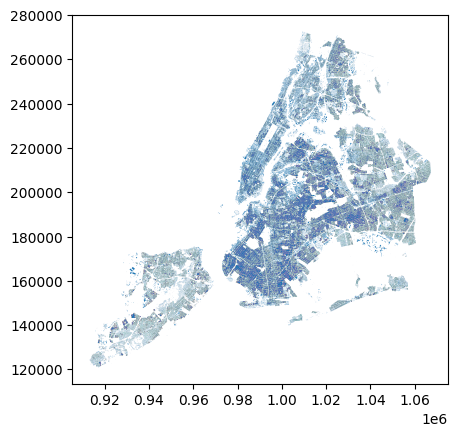

In [8]:
if SHOW_PLOTS:
    overlay_df = gpd.overlay(gdf_buildings, gdf_pluto, how="intersection")
    print(len(overlay_df))
    overlay_df.plot()

### LOAD + CHECK RASTERS

In [9]:
print("Loading reprojected LST + Indices...")

lst_tiff_path = "Landsat_LST_v5_median_0601_0901.tiff"
indices_tiff_path = "S2_indices_v5_median_0601_0901.tiff"

lst_raster = rxr.open_rasterio(lst_tiff_path)
lst_raster_2263 = lst_raster.rio.reproject("EPSG:2263")

indices_raster = rxr.open_rasterio(indices_tiff_path)
indices_raster_2263 = indices_raster.rio.reproject("EPSG:2263")

# Quick check for valid data
ratio_lst = (~lst_raster_2263.isnull()).mean().values
ratio_idx = (~indices_raster_2263.isnull()).mean().values

print(f"LST valid ratio: {ratio_lst:.3f}")
print(f"Indices valid ratio: {ratio_idx:.3f}")
if ratio_lst == 0.0:
    print("WARNING: LST raster is entirely NaN.")
if ratio_idx == 0.0:
    print("WARNING: Indices raster is entirely NaN.")

print("LST raster bounds:", lst_raster_2263.rio.bounds())
print("Indices raster bounds:", indices_raster_2263.rio.bounds())

Loading reprojected LST + Indices...
LST valid ratio: 1.000
Indices valid ratio: 0.995
LST raster bounds: (981437.4489166049, 212457.54099916507, 1023088.2146540903, 260009.54459268012)
Indices raster bounds: (981462.3462672028, 212512.28574393364, 1023050.6163433938, 259944.0070645518)


NDVI Tiff Bounds: BoundingBox(left=-74.0101509162774, bottom=40.749820337765, right=-73.85977362558391, top=40.8802551203737)
CRS: EPSG:4326
Width, Height: 558 484
Number of bands: 1


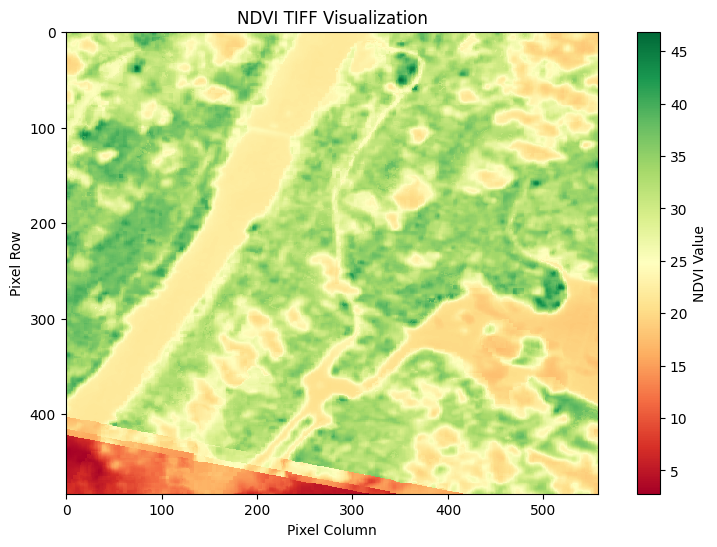

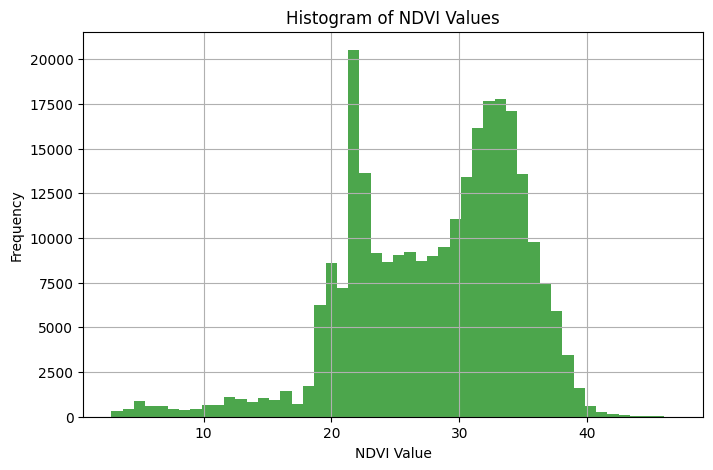

In [10]:
if SHOW_PLOTS:
    # Open the TIFF file
    with rasterio.open(lst_tiff_path) as src:
        # Print metadata
        print("NDVI Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="NDVI Value")
    plt.title("NDVI TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of NDVI Values")
    plt.xlabel("NDVI Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

NDVI Tiff Bounds: BoundingBox(left=-74.0100610851599, bottom=40.75, right=-73.85995328781891, top=40.8800754581387)
CRS: EPSG:4326
Width, Height: 1671 1448
Number of bands: 5


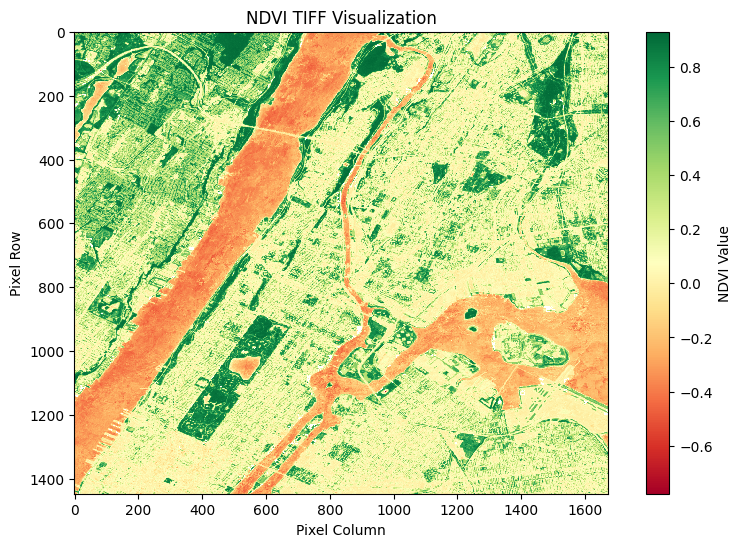

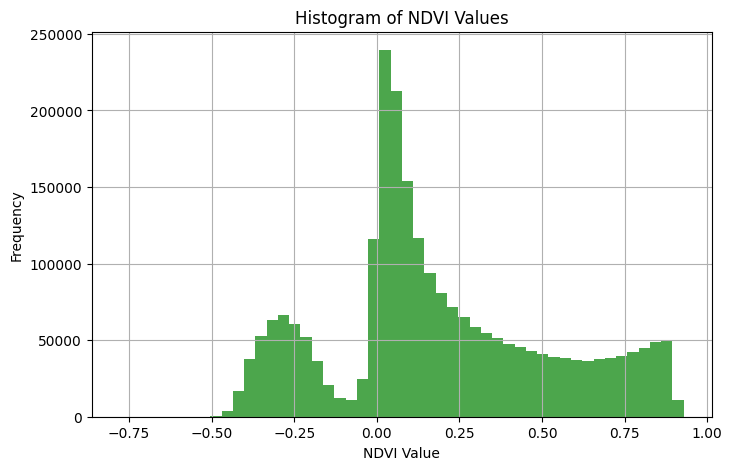

In [11]:
if SHOW_PLOTS:
    # Open the TIFF file
   
    with rasterio.open(indices_tiff_path) as src:
        # Print metadata
        print("NDVI Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="NDVI Value")
    plt.title("NDVI TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of NDVI Values")
    plt.xlabel("NDVI Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

### LOAD TRAINING DATA

In [12]:
print("Loading Training CSV ...")
df_train = pd.read_csv("./data/Training_data_uhi_index 2025-02-04.csv")
print("df_train shape:", df_train.shape)
gdf_train_csv = gpd.GeoDataFrame(
    df_train,
    geometry=[Point(lon, lat) for lon, lat in zip(df_train["Longitude"], df_train["Latitude"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
# Optionally, if your training CSV is a subset of your building footprints,
# you can use a nearest spatial join; however, here we choose to extract features row-by-row.
gdf_train = gdf_train_csv.copy()  # We'll enrich this gdf row-by-row.

# --- Prepare dictionaries for per-point features and for PLUTO features.
# For per-point features (computed row-by-row):
features_dict_train = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}

# For MapPLUTO features, initialize a dictionary with keys = pluto_columns.
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")

Loading Training CSV ...
df_train shape: (11269, 4)
total rows: 11269


In [13]:
import geopandas as gpd
from shapely.geometry import box

# 1. Extract the total bounds of gdf_train
minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds

# 2. Define a buffer in the same units as your CRS (here, meters)
buffer = 1000  # adjust this value if you need a slightly larger or smaller margin

# 3. Create an expanded bounding box
expanded_bbox = box(minx_train - buffer, 
                    miny_train - buffer, 
                    maxx_train + buffer, 
                    maxy_train + buffer)

# Optional: If you want to see the coordinates of the expanded bounding box:
print("Expanded Bounding Box:", expanded_bbox.bounds)

# 4. Create a sub-dataframe from gdf_buildings 1GB that only contains features intersecting the expanded bbox
gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# Check the total bounds of the new subset
print("Subset Total Bounds:", gdf_buildings.total_bounds)
print("Train Total Bounds:", gdf_train.total_bounds)

Expanded Bounding Box: (984785.411382811, 214727.52933294218, 1018620.8402454641, 253422.67726362712)
Subset Total Bounds: [ 984092.05017281  214355.31379316 1019093.78397498  253922.21989541]
Train Total Bounds: [ 985785.41138281  215727.52933294 1017620.84024546  252422.67726363]


In [14]:
# 1) Run DBSCAN
N_LARGEST = 4
eps_m = 500
min_samples = 50
gdf_buildings, cluster_centroids, top_clusters = run_dbscan_on_buildings(
    gdf_buildings, 
    eps_m=eps_m,
    min_samples=min_samples,
    N_LARGEST=N_LARGEST
)

print(f"Top {N_LARGEST} clusters by building count: {top_clusters}")
print("Cluster centroids for top N largest clusters:")
for (lbl, (cx, cy)) in cluster_centroids:
    print(f"  Cluster {lbl} => centroid=({cx:.2f}, {cy:.2f})")

Top 4 clusters by building count: [3 0 2 5]
Cluster centroids for top N largest clusters:
  Cluster 3 => centroid=(1009637.66, 218641.78)
  Cluster 0 => centroid=(996889.92, 229691.73)
  Cluster 2 => centroid=(1010724.93, 238797.23)
  Cluster 5 => centroid=(1012340.88, 249517.53)


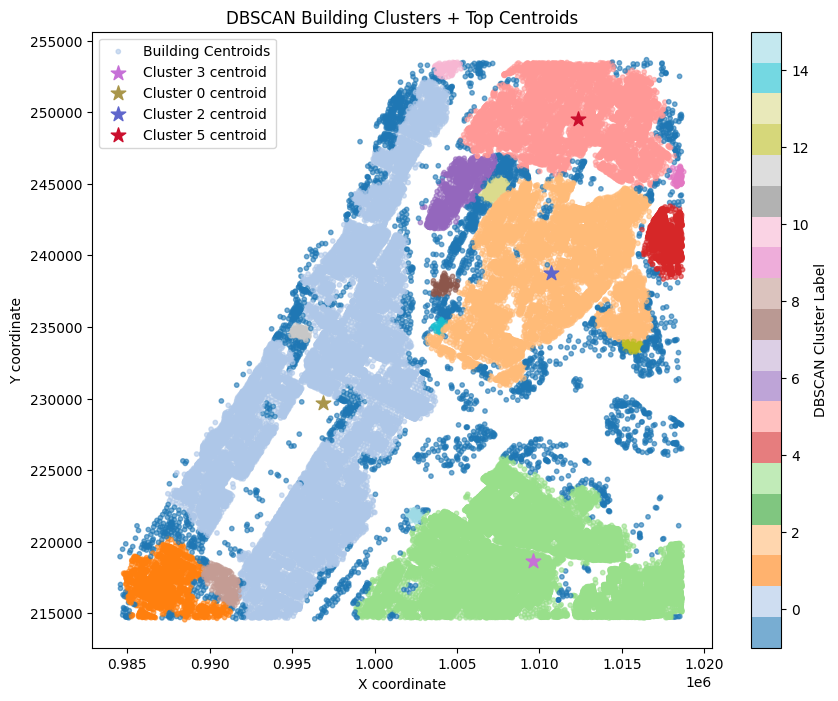

In [15]:
if SHOW_PLOTS:
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    labels_bldg = gdf_buildings["bldg_cluster"].values
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        coords_bldg[:, 0],
        coords_bldg[:, 1],
        c=labels_bldg,
        cmap='tab20',
        s=10,
        alpha=0.6,
        label="Building Centroids"
    )
    # Mark cluster centroids
    for (lbl, (cx, cy)) in cluster_centroids:
        random_color = mcolors.to_rgba((random.random(), random.random(), random.random()))
        ax.scatter(cx, cy, color=random_color, marker='*', s=120, label=f"Cluster {lbl} centroid")
    
    ax.set_title("DBSCAN Building Clusters + Top Centroids")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    cb = plt.colorbar(scatter, ax=ax, label="DBSCAN Cluster Label")
    
    # Deduplicate legend entries
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="best")
    
    plt.show()

### BUILD TRAINING FEATURES

In [16]:
print("Building training features...")

# We'll store arrays in a dictionary keyed exactly by the same name as FEATURE_FLAGS
# Initialize per-point feature dictionary (for features computed row‑by‑row)
features_dict_train = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}

# Initialize a dictionary for PLUTO features (for the columns defined in pluto_columns)
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")
for i, row in gdf_train.iterrows():
    if i % 1000 == 0:
        percent_done = (i / total_rows) * 100
        print(f"  -> {percent_done:.2f}% done")

    geom = row.geometry

    # 7.1 building coverage (various radii)
    if FEATURE_FLAGS["building_cov_50m"]:
        b50 = building_coverage_fraction(geom, gdf_buildings, 50)
        features_dict_train["building_cov_50m"].append(b50)

    if FEATURE_FLAGS["building_cov_100m"]:
        b100 = building_coverage_fraction(geom, gdf_buildings, 100)
        features_dict_train["building_cov_100m"].append(b100)

    if FEATURE_FLAGS["building_cov_200m"]:
        b200 = building_coverage_fraction(geom, gdf_buildings, 200)
        features_dict_train["building_cov_200m"].append(b200)

    if FEATURE_FLAGS["building_cov_500m"]:
        b500 = building_coverage_fraction(geom, gdf_buildings, 500)
        features_dict_train["building_cov_500m"].append(b500)

    # 7.2 distance to water
    if FEATURE_FLAGS["distance_water"]:
        dist_w = distance_to_polygons(geom, gdf_water)
        features_dict_train["distance_water"].append(dist_w)

    # 7.3 distance to parks
    if FEATURE_FLAGS["distance_parks"]:
        dist_p = distance_to_polygons(geom, gdf_parks)
        features_dict_train["distance_parks"].append(dist_p)

    # 7.4 street tree coverage in 500m
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
        features_dict_train["street_tree_cov_500m"].append(tree_500)

    # 7.5 distance to closest subway station
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_subway = gdf_stations.geometry.distance(geom)
        dist_sub = dists_subway.min() if len(dists_subway) > 0 else 0
        features_dict_train["dist_to_closest_subway_station"].append(dist_sub)

    # 7.6 Raster-based: lst_value, ndvi_value, ndbi_value, ndwi_value, evi_value, mndwi_value
    if FEATURE_FLAGS["lst_value"]:
        lst_val = extract_raster_value(geom, lst_raster_2263, band_index=1)
        features_dict_train["lst_value"].append(lst_val)

    if FEATURE_FLAGS["ndvi_value"]:
        ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
        features_dict_train["ndvi_value"].append(ndvi_val)

    if FEATURE_FLAGS["ndbi_value"]:
        ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
        features_dict_train["ndbi_value"].append(ndbi_val)

    if FEATURE_FLAGS["ndwi_value"]:
        ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
        features_dict_train["ndwi_value"].append(ndwi_val)

    if FEATURE_FLAGS["evi_value"]:
        evi_value = extract_raster_value(geom, indices_raster_2263, band_index=4)
        features_dict_train["evi_value"].append(evi_value)
        
    if FEATURE_FLAGS["mndwi_value"]:
        mndwi_value = extract_raster_value(geom, indices_raster_2263, band_index=5)
        features_dict_train["mndwi_value"].append(mndwi_value)

    # 7.7 Mathematically calculated neighbourhoods and distances from their centroids
    if FEATURE_FLAGS["building_cluster_id"]:
        c_str = nearest_cluster_centroid_label(geom, cluster_centroids)
        if c_str is not None:
            c_str = f"N{c_str}"
        else:
            c_str = "other"
        # print(c_str)
        features_dict_train["building_cluster_id"].append(c_str)
    
    if FEATURE_FLAGS["dist_to_closest_cluster_centroid"]:
        dmin = dist_to_closest_cluster_centroid_feature(geom, cluster_centroids)
        features_dict_train["dist_to_closest_cluster_centroid"].append(dmin)

    # 7.8 Extract PLUTO features for this point.
    if FEATURE_FLAGS["map_pluto_data"]:
        # pluto_feats = get_pluto_features(geom, gdf_pluto, pluto_columns)
        # for col in pluto_columns:
        #     pluto_features_dict[col].append(pluto_feats.get(col, np.nan))
        
        # 1) For numeric columns => do radius aggregator
        radius = 500
        numeric_agg_vals = {}
        if num_cols:
            numeric_agg_vals = aggregate_pluto_numerics_in_radius(geom, gdf_pluto, num_cols, radius=radius)
        
        # 2) For categorical columns => keep old approach or do something else
        cat_feats = {}
        if cat_cols:
            cat_feats = get_pluto_features(geom, gdf_pluto, cat_cols)
    
        # 3) Store them in pluto_features_dict
        for col in num_cols:
            pluto_features_dict[col].append(numeric_agg_vals.get(col, np.nan))
        for col in cat_cols:
            pluto_features_dict[col].append(cat_feats.get(col, np.nan))

print("100.00% done")

Building training features...
total rows: 11269
  -> 0.00% done
  -> 8.87% done
  -> 17.75% done
  -> 26.62% done
  -> 35.50% done
  -> 44.37% done
  -> 53.24% done
  -> 62.12% done
  -> 70.99% done
  -> 79.87% done
  -> 88.74% done
  -> 97.61% done
100.00% done


In [17]:
# Cap y above 99.5th percentile
cap_quantile= 0.995
cap_val= gdf_train["UHI Index"].quantile(cap_quantile)
mask_out= (gdf_train["UHI Index"] > cap_val)
if mask_out.sum()>0:
    print(f"Capping {mask_out.sum()} outliers above Q={cap_quantile} at {cap_val:.3f}")
    gdf_train.loc[mask_out, "UHI Index"] = cap_val

Capping 55 outliers above Q=0.995 at 1.039


### CREATE TRAINING DATAFRAME

In [18]:
# --- Add per-point features to gdf_train
for feat_key, feat_values in features_dict_train.items():
    print(f"Per-point: {feat_key}: {len(feat_values)}")
    gdf_train[feat_key] = feat_values

# --- Add PLUTO features to gdf_train
for col, values in pluto_features_dict.items():
    print(f"PLUTO: {col}: {len(values)}")
    gdf_train[col] = values

Per-point: building_cov_100m: 11269
Per-point: building_cov_500m: 11269
Per-point: distance_water: 11269
Per-point: distance_parks: 11269
Per-point: street_tree_cov_500m: 11269
Per-point: dist_to_closest_subway_station: 11269
Per-point: dist_to_closest_cluster_centroid: 11269
Per-point: building_cluster_id: 11269
Per-point: lst_value: 11269
Per-point: ndvi_value: 11269
Per-point: ndbi_value: 11269
Per-point: ndwi_value: 11269
Per-point: evi_value: 11269
Per-point: mndwi_value: 11269
PLUTO: NumFloors: 11269
PLUTO: NumBldgs: 11269
PLUTO: UnitsRes: 11269
PLUTO: UnitsTotal: 11269
PLUTO: LotArea: 11269
PLUTO: BldgArea: 11269
PLUTO: ComArea: 11269
PLUTO: ResArea: 11269
PLUTO: FactryArea: 11269
PLUTO: AssessLand: 11269
PLUTO: AssessTot: 11269
PLUTO: ExemptTot: 11269
PLUTO: BuiltFAR: 11269
PLUTO: ResidFAR: 11269
PLUTO: CommFAR: 11269
PLUTO: FacilFAR: 11269
PLUTO: YearBuilt: 11269
PLUTO: Borough: 11269
PLUTO: ZoneDist1: 11269
PLUTO: Overlay1: 11269
PLUTO: LandUse: 11269
PLUTO: BldgClass: 11269


In [19]:
print(gdf_train.columns)

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index', 'geometry', 'building_cov_100m', 'building_cov_500m', 'distance_water', 'distance_parks', 'street_tree_cov_500m', 'dist_to_closest_subway_station', 'dist_to_closest_cluster_centroid', 'building_cluster_id', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value', 'NumFloors', 'NumBldgs', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'FactryArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt', 'Borough', 'ZoneDist1', 'Overlay1', 'LandUse', 'BldgClass'], dtype='object')


In [20]:
# --- Fill missing values in PLUTO features (training)
for col in cat_cols:
    if col in gdf_train.columns:
        if col == "Borough":
            gdf_train[col] = gdf_train[col].fillna("MN")
        else:
            gdf_train[col] = gdf_train[col].fillna("UNKNOWN")

# For year columns, convert zeros to NaN first
year_cols = ["YearBuilt"]
for col in year_cols:
    gdf_train[col] = gdf_train[col].replace(0, np.nan)

# pluto_num_cols = [col for col in pluto_columns if col not in total_cat_cols]
for col in num_cols:
    if col in gdf_train.columns:
        # You can fill missing numeric values with 0 or with the median
        median_val = gdf_train[col].median()
        gdf_train[col] = gdf_train[col].fillna(median_val)

In [21]:
total_cat_cols = cat_cols + ["building_cluster_id"]
total_cat_cols

['Borough',
 'ZoneDist1',
 'Overlay1',
 'LandUse',
 'BldgClass',
 'building_cluster_id']

In [22]:
# --- Process categorical PLUTO columns via one-hot encoding (training)
# (Use the same categorical list as above.)
for col in total_cat_cols:
    gdf_train[col] = gdf_train[col].astype(str)

# Compute one-hot encoded dummy variables
dummies = pd.get_dummies(gdf_train[total_cat_cols], prefix=total_cat_cols)

# Store the list of dummy columns from training for later use
dummy_cols_train = list(dummies.columns)
dummy_cols_train

['Borough_BX',
 'Borough_MN',
 'ZoneDist1_C1-8A',
 'ZoneDist1_C1-8X',
 'ZoneDist1_C1-9',
 'ZoneDist1_C2-7',
 'ZoneDist1_C2-7A',
 'ZoneDist1_C2-8',
 'ZoneDist1_C2-8A',
 'ZoneDist1_C4-4',
 'ZoneDist1_C4-4D',
 'ZoneDist1_C4-5X',
 'ZoneDist1_C4-6',
 'ZoneDist1_C4-6A',
 'ZoneDist1_C4-7',
 'ZoneDist1_C5-1',
 'ZoneDist1_C5-1A',
 'ZoneDist1_C5-2',
 'ZoneDist1_C5-2.5',
 'ZoneDist1_C5-3',
 'ZoneDist1_C6-1',
 'ZoneDist1_C6-2',
 'ZoneDist1_C6-3',
 'ZoneDist1_C6-3D',
 'ZoneDist1_C6-3X',
 'ZoneDist1_C6-6',
 'ZoneDist1_C8-3',
 'ZoneDist1_C8-4',
 'ZoneDist1_M1-1',
 'ZoneDist1_M1-1/R7-2',
 'ZoneDist1_M1-2',
 'ZoneDist1_M1-2/R6A',
 'ZoneDist1_M1-3',
 'ZoneDist1_M1-4',
 'ZoneDist1_M1-4/R7X',
 'ZoneDist1_M1-5',
 'ZoneDist1_M1-6/R10',
 'ZoneDist1_M2-3',
 'ZoneDist1_M3-1',
 'ZoneDist1_M3-2',
 'ZoneDist1_PARK',
 'ZoneDist1_R10',
 'ZoneDist1_R10A',
 'ZoneDist1_R10H',
 'ZoneDist1_R6',
 'ZoneDist1_R6A',
 'ZoneDist1_R7-1',
 'ZoneDist1_R7-2',
 'ZoneDist1_R7A',
 'ZoneDist1_R7B',
 'ZoneDist1_R7D',
 'ZoneDist1_R7X',

In [23]:
# Drop the original categorical columns and concatenate the dummy variables:
gdf_train = gdf_train.drop(columns=total_cat_cols)
gdf_train = pd.concat([gdf_train, dummies], axis=1)
print("One-hot encoded PLUTO categorical features added to training data.")

# --- Build final global feature list for training
# Per-point features come from features_dict_train (they have been added to gdf_train already)
per_point_features = list(features_dict_train.keys())
# PLUTO numeric features (those originally in pluto_columns, except the ones processed as categorical)
pluto_numeric_features = [col for col in pluto_columns if col not in cat_cols]
# Final training features: order = per-point features, then numeric PLUTO features, then dummy features.
final_feature_cols = [col for col in (per_point_features + pluto_numeric_features + dummy_cols_train) if col not in total_cat_cols]
print("Final feature columns used (training):")
print(final_feature_cols)

One-hot encoded PLUTO categorical features added to training data.
Final feature columns used (training):
['building_cov_100m', 'building_cov_500m', 'distance_water', 'distance_parks', 'street_tree_cov_500m', 'dist_to_closest_subway_station', 'dist_to_closest_cluster_centroid', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value', 'NumFloors', 'NumBldgs', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'FactryArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt', 'Borough_BX', 'Borough_MN', 'ZoneDist1_C1-8A', 'ZoneDist1_C1-8X', 'ZoneDist1_C1-9', 'ZoneDist1_C2-7', 'ZoneDist1_C2-7A', 'ZoneDist1_C2-8', 'ZoneDist1_C2-8A', 'ZoneDist1_C4-4', 'ZoneDist1_C4-4D', 'ZoneDist1_C4-5X', 'ZoneDist1_C4-6', 'ZoneDist1_C4-6A', 'ZoneDist1_C4-7', 'ZoneDist1_C5-1', 'ZoneDist1_C5-1A', 'ZoneDist1_C5-2', 'ZoneDist1_C5-2.5', 'ZoneDist1_C5-3', 'ZoneDist1_C6-1', 'ZoneDist1_C6-2', 'ZoneDist1_C6-3', 'ZoneDist1_C

In [24]:
df_train_feat = gdf_train[final_feature_cols].fillna(0.0)
X = df_train_feat.values
y = gdf_train["UHI Index"].values

print("Final train feature shape:", X.shape)

Final train feature shape: (11269, 253)


In [25]:
df_train_feat.describe(include='all')

,building_cov_100m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,Borough_BX,Borough_MN,ZoneDist1_C1-8A,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C2-8A,ZoneDist1_C4-4,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-2.5,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-6/R10,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R8X,ZoneDist1_R9,ZoneDist1_R9A,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-3,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G8,BldgClass_G9,BldgClass_GU,BldgClass_H1,BldgClass_H3,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_HB,BldgClass_HH,BldgClass_HR,BldgClass_I1,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J3,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M2,BldgClass_M3,BldgClass_M4,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O3,BldgClass_O4,BldgClass_O5,BldgClass_O6,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P2,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q3,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_QG,BldgClass_R0,BldgClass_R1,BldgClass_R2,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_R6,BldgClass_RA,BldgClass_RB,BldgClass_RC,BldgClass_RD,BldgClass_RM,BldgClass_RR,BldgClass_S0,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T2,BldgClass_U0,BldgClass_U1,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W4,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y2,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,building_cluster_id_N0,building_cluster_id_N2,building_cluster_id_N5
count,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,1.126900e+04,1.126900e+04,1.126900e+04,11269.000000,11269.000000,1.126900e+04,1.126900e+04,1.126900e+04,11269.000000,11269.000000,11269.000000,11269.000000,11269.000000,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11269,11

In [26]:
df_train_feat

,building_cov_100m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,Borough_BX,Borough_MN,ZoneDist1_C1-8A,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C2-8A,ZoneDist1_C4-4,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-2.5,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-6/R10,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R8X,ZoneDist1_R9,ZoneDist1_R9A,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-3,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G8,BldgClass_G9,BldgClass_GU,BldgClass_H1,BldgClass_H3,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_HB,BldgClass_HH,BldgClass_HR,BldgClass_I1,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J3,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M2,BldgClass_M3,BldgClass_M4,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O3,BldgClass_O4,BldgClass_O5,BldgClass_O6,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P2,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q3,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_QG,BldgClass_R0,BldgClass_R1,BldgClass_R2,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_R6,BldgClass_RA,BldgClass_RB,BldgClass_RC,BldgClass_RD,BldgClass_RM,BldgClass_RR,BldgClass_S0,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T2,BldgClass_U0,BldgClass_U1,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W4,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y2,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,building_cluster_id_N0,building_cluster_id_N2,building_cluster_id_N5
0,0.287945,0.406067,3499.356358,546.033740,0.001908,750.912129,4958.633573,35.854352,0.034611,0.131743,-0.084900,0.187668,-0.214246,3.468938,1.703391,19.661965,22.641152,2.165221e+04,45780.743625,26520.364037,19175.274648,0.0,1.516213e+05,2.511299e+06,1.773495e+06,2.146749,2.690260,0.357924,4.990941,1946.474092,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [27]:
gdf_train

,Longitude,Latitude,datetime,UHI Index,geometry,building_cov_100m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,Borough_BX,Borough_MN,ZoneDist1_C1-8A,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C2-8A,ZoneDist1_C4-4,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-2.5,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-6/R10,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R8X,ZoneDist1_R9,ZoneDist1_R9A,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-3,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G8,BldgClass_G9,BldgClass_GU,BldgClass_H1,BldgClass_H3,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_HB,BldgClass_HH,BldgClass_HR,BldgClass_I1,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J3,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M2,BldgClass_M3,BldgClass_M4,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O3,BldgClass_O4,BldgClass_O5,BldgClass_O6,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P2,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q3,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_QG,BldgClass_R0,BldgClass_R1,BldgClass_R2,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_R6,BldgClass_RA,BldgClass_RB,BldgClass_RC,BldgClass_RD,BldgClass_RM,BldgClass_RR,BldgClass_S0,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T2,BldgClass_U0,BldgClass_U1,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W4,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y2,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,building_cluster_id_N0,building_cluster_id_N2,building_cluster_id_N5
0,-73.919037,40.814292,24-07-2021 15:53,1.034616,POINT (1006661.089 235955.883),0.287945,0.406067,3499.356358,546.033740,0.001908,750.912129,4958.633573,35.854352,0.034611,0.131743,-0.084900,0.187668,-0.214246,3.468938,1.703391,19.661965,22.641152,2.165221e+04,45780.743625,26520.364037,19175.274648,0.0,1.516213e+05,2.511299e+06,1.773495e+06,2.146749,2.690260,0.357924,4.990941,1946.474092,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

### DEFINE STRATIFIED CV

In [28]:
def make_stratified_bins(target, n_bins=10):
    """Bin the continuous target into discrete intervals for use in StratifiedKFold."""
    bins = pd.qcut(target, q=n_bins, duplicates="drop")
    return bins.astype(str)

K_FOLDS = 10
y_bins = make_stratified_bins(y, n_bins=10)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

### MODEL DEFINITIONS & HYPERPARAMETERS GRID

In [29]:
models_and_params = {
    "BayesianRidge": (
        BayesianRidge(),
        {
            "alpha_init": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
            "lambda_init": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
        },
        30
    ),
    "ElasticNet": (
        ElasticNet(random_state=RANDOM_SEED),
        {
            "alpha": [0.001, 0.005, 0.01, 0.1, 1.0],
            "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.8, 0.9],
        },
        30
    ),
    "XGBoost": (
        xgb.XGBRegressor(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric="rmse"),
        {
            "n_estimators": [100, 150, 200, 250, 300, 400, 500, 600, 700, 800],
            "learning_rate": [0.01, 0.05, 0.1, 0.15],
            "max_depth": [5, 10, 15, 20, 25, 30, 35, 40],
            # "booster": ["gbtree", "dart"],
            # "gamma": [0],
            # "reg_alpha": [0, 0.1, 0.5],
            # "reg_lambda": [1.0],
            "subsample": [0.7, 0.8, 0.9],
            "colsample_bytree": [0.7, 0.8, 0.9]
        },
        300
    ),
    "CatBoost": (
        CatBoostRegressor(silent=True, random_state=RANDOM_SEED),
        {
            "iterations": [100, 150, 200, 250, 300, 400, 500, 600, 700, 800],
            "max_depth": [5, 6, 7, 8, 9, 10, 11],
            "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
            "random_strength": [1, 2, 3, 4],
        },
        200
    ),
    "LightGBM": (
        lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
        {
            "n_estimators": [100, 150, 200, 250, 300, 400, 500, 600, 700, 800],
            "max_depth": [5, 10, 15, 20, 25, 30, 35, 40],
            "learning_rate": [0.05, 0.1, 0.15, 0.2],
            "subsample": [0.5, 0.7, 0.8, 0.9],
            "colsample_bytree": [0.6, 0.8],
            # "boosting_type": ["gbdt", "rf"],
            "num_leaves": [31, 63, 127],
            "reg_alpha": [0, 0.1, 0.5],
            "reg_lambda": [0.5, 1.0, 2.0],
        },
        200
    ),
    "HistGradientBoosting": (
        HistGradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            "max_iter": [100, 150, 200, 250, 300, 400, 500, 600, 700, 800],
            "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
            "max_depth": [5, 10, 15, 20, 25, 30, 35, 40],
            "max_leaf_nodes": [31, 63, 127],
            "l2_regularization": [0.0, 0.1, 0.5],
            "quantile": [0.1, 0.5, 0.8],
            "min_samples_leaf": [5, 10, 15],
            # "warm_start": [False],
        },
        200
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=RANDOM_SEED),
        {
            "splitter": ["best", "random"],
            "max_depth": [5, 10, 15, 20, 25, 30, 35, 40],
            "min_samples_leaf": [1, 2, 3, 4],
        },
        200
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 150, 200, 250, 300, 400, 500, 600, 700, 800],
            "max_depth": [5, 10, 15, 20, 25, 30, 35, 40],
            "min_samples_leaf": [1, 2, 3, 4],
            "min_samples_split": [2, 3, 4, 5],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            # "bootstrap": [False],
            # "oob_score": [False],
        },
        200
    ),
    "ExtraTrees": (
        ExtraTreesRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 150, 200, 250, 300, 400, 500, 600, 700, 800],
            "max_depth": [5, 10, 15, 20, 25, 30, 35, 40],
            "min_samples_split": [3, 4, 5, 6],
            "min_samples_leaf": [1, 2, 3, 4],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            # "ccp_alpha": [0.0, 0.001],
            # "bootstrap": [False],
            # "oob_score": [False],
        },
        300
    ),
    "KNeighbors": (
        KNeighborsRegressor(),
        {
            "n_neighbors": [2, 3, 4, 5],
            "weights": ["uniform", "distance"],
            "p": [1, 2, 3, 4],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [5, 10, 15, 20, 25, 30, 35, 40],
            "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        },
        1000
    ),
    # "NeuralNet": (
    #     MLPRegressor(random_state=RANDOM_SEED, max_iter=500),
    #     {
    #         "hidden_layer_sizes": [
    #             (64,), (128,), (64,64), (128,64),
    #         ],
    #         "activation": ["relu", "tanh"],
    #         "alpha": [1e-5, 1e-4, 1e-3],  # L2 reg
    #         "learning_rate_init": [0.001, 0.01],
    #         "solver": ["adam"],  # LBFGS is slower, sgd is less stable
    #     },
    #     10
    # ),
    # "SVR": (
    #     SVR(),
    #     {
    #         "kernel": ["rbf", "linear", "poly"],
    #         "C": [0.1, 1, 10],
    #         "epsilon": [0.01, 0.1, 0.5, 1.0],
    #         "gamma": ["scale"],
    #     },
    #     20
    # ),
    # "GPR": (
    #     GaussianProcessRegressor(random_state=RANDOM_SEED),
    #     {
    #         # We'll try a small kernel set
    #         "alpha": [1e-10, 1e-5, 1e-2],
    #         "kernel": [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)],
    #     },
    #     2
    # ),
}

### RANDOM SEARCH FOR EACH MODEL

In [30]:
results = []
for model_name, (model, param_grid, n_iter) in models_and_params.items():
    print(f"\n=== Searching {model_name} ===")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,  # <--- use the model-specific n_iter
        cv=list(skf.split(X, y_bins)),
        scoring="r2",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=3
    )
    search.fit(X, y)
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    results.append({
        "Model": model_name,
        "Best Estimator": best_estimator,
        "Best Score (CV)": best_score,
        "Best Params": best_params
    })

results_df = pd.DataFrame(results).sort_values(by="Best Score (CV)", ascending=False)
print("\nFinal Cross-Val Results:\n", results_df)
results_df.to_csv("results_df_v20.csv", index=False, sep='|')


=== Searching BayesianRidge ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits

=== Searching ElasticNet ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits

=== Searching XGBoost ===
Fitting 10 folds for each of 300 candidates, totalling 3000 fits

=== Searching CatBoost ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching LightGBM ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching HistGradientBoosting ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching DecisionTree ===
Fitting 10 folds for each of 48 candidates, totalling 480 fits

=== Searching RandomForest ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching ExtraTrees ===
Fitting 10 folds for each of 300 candidates, totalling 3000 fits

=== Searching KNeighbors ===
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits

Final Cross-Val Results:
                  

In [31]:
results_df

,Model,Best Estimator,Best Score (CV),Best Params
8,ExtraTrees,"(ExtraTreeRegressor(max_depth=30, min_samples_...",0.972896,"{'n_estimators': 700, 'min_samples_split': 3, ..."
2,XGBoost,"XGBRegressor(base_score=None, booster=None, ca...",0.971532,"{'subsample': 0.8, 'n_estimators': 800, 'max_d..."
7,RandomForest,"(DecisionTreeRegressor(max_depth=25, max_featu...",0.968123,"{'n_estimators': 500, 'min_samples_split': 2, ..."
4,LightGBM,"LGBMRegressor(colsample_bytree=0.6, learning_r...",0.967973,"{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alp..."
3,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,0.964488,"{'random_strength': 1, 'max_depth': 10, 'learn..."
5,HistGradientBoosting,HistGradientBoostingRegressor(l2_regularizatio...,0.958230,"{'quantile': 0.1, 'min_samples_leaf': 10, 'max..."
6,DecisionTree,"DecisionTreeRegressor(max_depth=30, min_sample...",0.928143,"{'splitter': 'best', 'min_samples_leaf': 2, 'm..."
9,KNeighbors,"KNeighborsRegressor(algorithm='ball_tree', lea...",0.711719,"{'weights': 'distance', 'p': 1, 'n_neighbors':..."
0,BayesianRidge,"BayesianRidge(alpha_init=1e-07, lambda_init=1e...",0.566915,"{'lambda_init': 1e-08, 'alpha_init': 1e-07}"
1,ElasticNet,"ElasticNet(alpha=0.001, l1_ratio=0.1, random_s...",0.444200,"{'l1_ratio': 0.1, 'alpha': 0.001}"


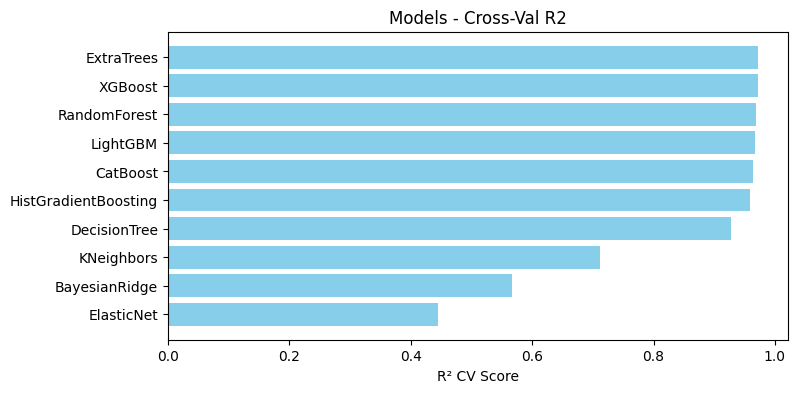

In [32]:
if SHOW_PLOTS:
    plt.figure(figsize=(8,4))
    plt.barh(results_df["Model"], results_df["Best Score (CV)"], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("R² CV Score")
    plt.title("Models - Cross-Val R2")
    plt.show()

### VALIDATION DATA

In [33]:
print("Loading validation (submission) data...")
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")

gdf_val = gpd.GeoDataFrame(
    df_val,
    geometry=[Point(lon, lat) for lon, lat in zip(df_val.Longitude, df_val.Latitude)],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

Loading validation (submission) data...


### FEATURE ENGINEERING FOR VALIDATION SET

In [34]:
print("Building validation features...")

features_dict_val = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows_val = len(gdf_val)
print(f"total rows: {total_rows_val}")
for idx, row in gdf_val.iterrows():
    if idx % 100 == 0:
        percent_done = (idx / total_rows_val) * 100
        print(f"  -> {percent_done:.2f}% done")

    geom = row.geometry

    # 7.1 building coverage (various radii)
    if FEATURE_FLAGS["building_cov_50m"]:
        b50 = building_coverage_fraction(geom, gdf_buildings, 50)
        features_dict_val["building_cov_50m"].append(b50)

    if FEATURE_FLAGS["building_cov_100m"]:
        b100 = building_coverage_fraction(geom, gdf_buildings, 100)
        features_dict_val["building_cov_100m"].append(b100)

    if FEATURE_FLAGS["building_cov_200m"]:
        b200 = building_coverage_fraction(geom, gdf_buildings, 200)
        features_dict_val["building_cov_200m"].append(b200)

    if FEATURE_FLAGS["building_cov_500m"]:
        b500 = building_coverage_fraction(geom, gdf_buildings, 500)
        features_dict_val["building_cov_500m"].append(b500)

    # 7.2 distance to water
    if FEATURE_FLAGS["distance_water"]:
        dw = distance_to_polygons(geom, gdf_water)
        features_dict_val["distance_water"].append(dw)

    # 7.3 distance to parks
    if FEATURE_FLAGS["distance_parks"]:
        dp = distance_to_polygons(geom, gdf_parks)
        features_dict_val["distance_parks"].append(dp)

    # 7.4 street tree coverage in 500m
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
        features_dict_val["street_tree_cov_500m"].append(tree_500)

    # 7.5 distance to closest subway station
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_sub = gdf_stations.geometry.distance(geom)
        dist_sub = dists_sub.min() if len(dists_sub) > 0 else 0
        features_dict_val["dist_to_closest_subway_station"].append(dist_sub)

    # 7.6 Raster-based: lst_value, ndvi_value, ndbi_value, ndwi_value, evi_value, mndwi_value
    if FEATURE_FLAGS["lst_value"]:
        lv = extract_raster_value(geom, lst_raster_2263, band_index=1)
        features_dict_val["lst_value"].append(lv)

    if FEATURE_FLAGS["ndvi_value"]:
        ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
        features_dict_val["ndvi_value"].append(ndvi_val)

    if FEATURE_FLAGS["ndbi_value"]:
        ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
        features_dict_val["ndbi_value"].append(ndbi_val)

    # ndwi_value
    if FEATURE_FLAGS["ndwi_value"]:
        ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
        features_dict_val["ndwi_value"].append(ndwi_val)

    if FEATURE_FLAGS["evi_value"]:
        evi_value = extract_raster_value(geom, indices_raster_2263, band_index=4)
        features_dict_val["evi_value"].append(evi_value)

    if FEATURE_FLAGS["mndwi_value"]:
        mndwi_value = extract_raster_value(geom, indices_raster_2263, band_index=5)
        features_dict_val["mndwi_value"].append(mndwi_value)

    # 7.7 Mathematically calculated neighbourhoods and distances from their centroids
    if FEATURE_FLAGS["building_cluster_id"]:
        c_str = nearest_cluster_centroid_label(geom, cluster_centroids)
        if c_str is not None:
            c_str = f"N{c_str}"
        else:
            c_str = "other"
        features_dict_val["building_cluster_id"].append(c_str)

    if FEATURE_FLAGS["dist_to_closest_cluster_centroid"]:
        dmin = dist_to_closest_cluster_centroid_feature(geom, cluster_centroids)
        features_dict_val["dist_to_closest_cluster_centroid"].append(dmin)

    # 7.8 Extract PLUTO features for this point.
    if FEATURE_FLAGS["map_pluto_data"]:
        # pluto_feats = get_pluto_features(geom, gdf_pluto, pluto_columns)
        # for col in pluto_columns:
        #     pluto_features_dict[col].append(pluto_feats.get(col, np.nan))
        
        # 1) For numeric columns => do radius aggregator
        radius = 500
        numeric_agg_vals = {}
        if num_cols:
            numeric_agg_vals = aggregate_pluto_numerics_in_radius(geom, gdf_pluto, num_cols, radius=radius)
        
        # 2) For categorical columns => keep old approach or do something else
        cat_feats = {}
        if cat_cols:
            cat_feats = get_pluto_features(geom, gdf_pluto, cat_cols)
    
        # 3) Store them in pluto_features_dict
        for col in num_cols:
            pluto_features_dict[col].append(numeric_agg_vals.get(col, np.nan))
        for col in cat_cols:
            pluto_features_dict[col].append(cat_feats.get(col, np.nan))

print("100.00% done")

Building validation features...
total rows: 1040
  -> 0.00% done
  -> 9.62% done
  -> 19.23% done
  -> 28.85% done
  -> 38.46% done
  -> 48.08% done
  -> 57.69% done
  -> 67.31% done
  -> 76.92% done
  -> 86.54% done
  -> 96.15% done
100.00% done


In [35]:
# --- Add per-point features to the validation DataFrame (df_val)
for feat_key, feat_values in features_dict_val.items():
    df_val[feat_key] = feat_values
    print(f"Per-point: {feat_key}: {len(feat_values)}")

# --- Add PLUTO features to df_val
for col, values in pluto_features_dict.items():
    df_val[col] = values
    print(f"PLUTO: {col}: {len(values)}")

# --- Fill missing values in PLUTO features on df_val (same as training)
for col in cat_cols:
    if col in df_val.columns:
        if col == "Borough":
            df_val[col] = df_val[col].fillna("MN")
        else:
            df_val[col] = df_val[col].fillna("UNKNOWN")

# For year columns, convert zeros to NaN first
year_cols = ["YearBuilt"]
for col in year_cols:
    df_val[col] = df_val[col].replace(0, np.nan)
    
for col in num_cols:
    if col in df_val.columns:
        median_val = df_val[col].median()
        df_val[col] = df_val[col].fillna(median_val)

# --- Process categorical PLUTO columns via one-hot encoding
# Define the categorical columns (same as used in training)
for col in cat_cols:
    # df_val[col] = df_val[col].astype(str)
    if col in df_val.columns:
        df_val[col] = df_val[col].fillna("UNKNOWN")

# pluto_num_cols = [col for col in pluto_columns if col not in cat_cols]
for col in num_cols:
    if col in df_val.columns:
        # Here you can choose to fill with 0, or compute the median from non-missing values.
        df_val[col] = df_val[col].fillna(0)

Per-point: building_cov_100m: 1040
Per-point: building_cov_500m: 1040
Per-point: distance_water: 1040
Per-point: distance_parks: 1040
Per-point: street_tree_cov_500m: 1040
Per-point: dist_to_closest_subway_station: 1040
Per-point: dist_to_closest_cluster_centroid: 1040
Per-point: building_cluster_id: 1040
Per-point: lst_value: 1040
Per-point: ndvi_value: 1040
Per-point: ndbi_value: 1040
Per-point: ndwi_value: 1040
Per-point: evi_value: 1040
Per-point: mndwi_value: 1040
PLUTO: NumFloors: 1040
PLUTO: NumBldgs: 1040
PLUTO: UnitsRes: 1040
PLUTO: UnitsTotal: 1040
PLUTO: LotArea: 1040
PLUTO: BldgArea: 1040
PLUTO: ComArea: 1040
PLUTO: ResArea: 1040
PLUTO: FactryArea: 1040
PLUTO: AssessLand: 1040
PLUTO: AssessTot: 1040
PLUTO: ExemptTot: 1040
PLUTO: BuiltFAR: 1040
PLUTO: ResidFAR: 1040
PLUTO: CommFAR: 1040
PLUTO: FacilFAR: 1040
PLUTO: YearBuilt: 1040
PLUTO: Borough: 1040
PLUTO: ZoneDist1: 1040
PLUTO: Overlay1: 1040
PLUTO: LandUse: 1040
PLUTO: BldgClass: 1040


In [36]:
# --- Process categorical PLUTO columns via one-hot encoding (validation)
# Use the same list of categorical columns as training.
for col in total_cat_cols:
    df_val[col] = df_val[col].astype(str)

dummies_val = pd.get_dummies(df_val[total_cat_cols], prefix=total_cat_cols)

# **Reindex the validation dummy DataFrame to have the same columns (and order) as in training:**
dummies_val = dummies_val.reindex(columns=dummy_cols_train, fill_value=0)
dummy_cols_val = list(dummies_val.columns)
dummy_cols_val

['Borough_BX',
 'Borough_MN',
 'ZoneDist1_C1-8A',
 'ZoneDist1_C1-8X',
 'ZoneDist1_C1-9',
 'ZoneDist1_C2-7',
 'ZoneDist1_C2-7A',
 'ZoneDist1_C2-8',
 'ZoneDist1_C2-8A',
 'ZoneDist1_C4-4',
 'ZoneDist1_C4-4D',
 'ZoneDist1_C4-5X',
 'ZoneDist1_C4-6',
 'ZoneDist1_C4-6A',
 'ZoneDist1_C4-7',
 'ZoneDist1_C5-1',
 'ZoneDist1_C5-1A',
 'ZoneDist1_C5-2',
 'ZoneDist1_C5-2.5',
 'ZoneDist1_C5-3',
 'ZoneDist1_C6-1',
 'ZoneDist1_C6-2',
 'ZoneDist1_C6-3',
 'ZoneDist1_C6-3D',
 'ZoneDist1_C6-3X',
 'ZoneDist1_C6-6',
 'ZoneDist1_C8-3',
 'ZoneDist1_C8-4',
 'ZoneDist1_M1-1',
 'ZoneDist1_M1-1/R7-2',
 'ZoneDist1_M1-2',
 'ZoneDist1_M1-2/R6A',
 'ZoneDist1_M1-3',
 'ZoneDist1_M1-4',
 'ZoneDist1_M1-4/R7X',
 'ZoneDist1_M1-5',
 'ZoneDist1_M1-6/R10',
 'ZoneDist1_M2-3',
 'ZoneDist1_M3-1',
 'ZoneDist1_M3-2',
 'ZoneDist1_PARK',
 'ZoneDist1_R10',
 'ZoneDist1_R10A',
 'ZoneDist1_R10H',
 'ZoneDist1_R6',
 'ZoneDist1_R6A',
 'ZoneDist1_R7-1',
 'ZoneDist1_R7-2',
 'ZoneDist1_R7A',
 'ZoneDist1_R7B',
 'ZoneDist1_R7D',
 'ZoneDist1_R7X',

In [37]:
# Drop the original categorical columns and add the dummy columns.
df_val = df_val.drop(columns=total_cat_cols)
df_val = pd.concat([df_val, dummies_val], axis=1)
print("One-hot encoded PLUTO categorical features added to validation data.")

# --- Build final global feature list for validation
# Per-point features (computed row-by-row)
per_point_features_val = list(features_dict_val.keys())
# Use the same PLUTO numeric features as in training:
# (pluto_numeric_features was defined during training; if needed, recompute as below)
pluto_numeric_features = [col for col in pluto_columns if col not in total_cat_cols]
# Use the dummy columns from training (dummy_cols_train) for both training and validation.
# final_feature_cols_val = per_point_features_val + pluto_numeric_features + dummy_cols_val
final_feature_cols_val = [col for col in (per_point_features_val + pluto_numeric_features + dummy_cols_val) if col not in total_cat_cols]
print("Final feature columns for validation:")
print(final_feature_cols_val)

One-hot encoded PLUTO categorical features added to validation data.
Final feature columns for validation:
['building_cov_100m', 'building_cov_500m', 'distance_water', 'distance_parks', 'street_tree_cov_500m', 'dist_to_closest_subway_station', 'dist_to_closest_cluster_centroid', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value', 'NumFloors', 'NumBldgs', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'FactryArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt', 'Borough_BX', 'Borough_MN', 'ZoneDist1_C1-8A', 'ZoneDist1_C1-8X', 'ZoneDist1_C1-9', 'ZoneDist1_C2-7', 'ZoneDist1_C2-7A', 'ZoneDist1_C2-8', 'ZoneDist1_C2-8A', 'ZoneDist1_C4-4', 'ZoneDist1_C4-4D', 'ZoneDist1_C4-5X', 'ZoneDist1_C4-6', 'ZoneDist1_C4-6A', 'ZoneDist1_C4-7', 'ZoneDist1_C5-1', 'ZoneDist1_C5-1A', 'ZoneDist1_C5-2', 'ZoneDist1_C5-2.5', 'ZoneDist1_C5-3', 'ZoneDist1_C6-1', 'ZoneDist1_C6-2', 'ZoneDist1_C6-3', 'ZoneDist1_

In [38]:
df_val_feat = df_val[final_feature_cols_val].fillna(0.0)
X_val = df_val_feat.values
print("Validation shape:", X_val.shape)

Validation shape: (1040, 253)


In [39]:
df_val_feat.describe(include='all')

,building_cov_100m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,Borough_BX,Borough_MN,ZoneDist1_C1-8A,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C2-8A,ZoneDist1_C4-4,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-2.5,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-6/R10,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R8X,ZoneDist1_R9,ZoneDist1_R9A,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-3,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G8,BldgClass_G9,BldgClass_GU,BldgClass_H1,BldgClass_H3,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_HB,BldgClass_HH,BldgClass_HR,BldgClass_I1,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J3,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M2,BldgClass_M3,BldgClass_M4,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O3,BldgClass_O4,BldgClass_O5,BldgClass_O6,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P2,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q3,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_QG,BldgClass_R0,BldgClass_R1,BldgClass_R2,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_R6,BldgClass_RA,BldgClass_RB,BldgClass_RC,BldgClass_RD,BldgClass_RM,BldgClass_RR,BldgClass_S0,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T2,BldgClass_U0,BldgClass_U1,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W4,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y2,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,building_cluster_id_N0,building_cluster_id_N2,building_cluster_id_N5
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1.040000e+03,1.040000e+03,1.040000e+03,1040.000000,1040.000000,1.040000e+03,1.040000e+03,1.040000e+03,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040.0,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040.0,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040.0,1040.0,1040,104

In [40]:
df_val_feat

,building_cov_100m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,Borough_BX,Borough_MN,ZoneDist1_C1-8A,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C2-8A,ZoneDist1_C4-4,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-2.5,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-6/R10,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R8X,ZoneDist1_R9,ZoneDist1_R9A,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-3,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G8,BldgClass_G9,BldgClass_GU,BldgClass_H1,BldgClass_H3,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_HB,BldgClass_HH,BldgClass_HR,BldgClass_I1,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J3,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M2,BldgClass_M3,BldgClass_M4,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O3,BldgClass_O4,BldgClass_O5,BldgClass_O6,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P2,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q3,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_QG,BldgClass_R0,BldgClass_R1,BldgClass_R2,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_R6,BldgClass_RA,BldgClass_RB,BldgClass_RC,BldgClass_RD,BldgClass_RM,BldgClass_RR,BldgClass_S0,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T2,BldgClass_U0,BldgClass_U1,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W4,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y2,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,building_cluster_id_N0,building_cluster_id_N2,building_cluster_id_N5
0,0.238995,0.398831,1598.865845,16.915051,0.002833,1261.529232,5679.423728,31.373328,0.634263,-0.152237,-0.594313,2.550014,-0.486053,8.722022,1.429588,197.627328,249.749101,2.462012e+04,109324.642196,12333.571544,96828.288790,0.000000,2.664338e+06,1.140982e+07,6.746002e+06,3.928517,5.394870,0.595997,7.542995,1939.144577,False,True,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,False,False,False,False,False,0,False,False,F

In [41]:
df_val

,Longitude,Latitude,UHI Index,building_cov_100m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,NumFloors,NumBldgs,UnitsRes,UnitsTotal,LotArea,BldgArea,ComArea,ResArea,FactryArea,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,Borough_BX,Borough_MN,ZoneDist1_C1-8A,ZoneDist1_C1-8X,ZoneDist1_C1-9,ZoneDist1_C2-7,ZoneDist1_C2-7A,ZoneDist1_C2-8,ZoneDist1_C2-8A,ZoneDist1_C4-4,ZoneDist1_C4-4D,ZoneDist1_C4-5X,ZoneDist1_C4-6,ZoneDist1_C4-6A,ZoneDist1_C4-7,ZoneDist1_C5-1,ZoneDist1_C5-1A,ZoneDist1_C5-2,ZoneDist1_C5-2.5,ZoneDist1_C5-3,ZoneDist1_C6-1,ZoneDist1_C6-2,ZoneDist1_C6-3,ZoneDist1_C6-3D,ZoneDist1_C6-3X,ZoneDist1_C6-6,ZoneDist1_C8-3,ZoneDist1_C8-4,ZoneDist1_M1-1,ZoneDist1_M1-1/R7-2,ZoneDist1_M1-2,ZoneDist1_M1-2/R6A,ZoneDist1_M1-3,ZoneDist1_M1-4,ZoneDist1_M1-4/R7X,ZoneDist1_M1-5,ZoneDist1_M1-6/R10,ZoneDist1_M2-3,ZoneDist1_M3-1,ZoneDist1_M3-2,ZoneDist1_PARK,ZoneDist1_R10,ZoneDist1_R10A,ZoneDist1_R10H,ZoneDist1_R6,ZoneDist1_R6A,ZoneDist1_R7-1,ZoneDist1_R7-2,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R8X,ZoneDist1_R9,ZoneDist1_R9A,Overlay1_C1-3,Overlay1_C1-4,Overlay1_C1-5,Overlay1_C2-3,Overlay1_C2-4,Overlay1_C2-5,Overlay1_UNKNOWN,LandUse_01,LandUse_02,LandUse_03,LandUse_04,LandUse_05,LandUse_06,LandUse_07,LandUse_08,LandUse_09,LandUse_10,LandUse_11,LandUse_UNKNOWN,BldgClass_A1,BldgClass_A4,BldgClass_A5,BldgClass_A7,BldgClass_A9,BldgClass_B1,BldgClass_B2,BldgClass_B3,BldgClass_B9,BldgClass_C0,BldgClass_C1,BldgClass_C2,BldgClass_C3,BldgClass_C4,BldgClass_C5,BldgClass_C6,BldgClass_C7,BldgClass_C9,BldgClass_D1,BldgClass_D2,BldgClass_D3,BldgClass_D4,BldgClass_D5,BldgClass_D6,BldgClass_D7,BldgClass_D8,BldgClass_D9,BldgClass_E1,BldgClass_E2,BldgClass_E7,BldgClass_E9,BldgClass_F1,BldgClass_F2,BldgClass_F4,BldgClass_F5,BldgClass_F9,BldgClass_G1,BldgClass_G2,BldgClass_G3,BldgClass_G4,BldgClass_G5,BldgClass_G6,BldgClass_G7,BldgClass_G8,BldgClass_G9,BldgClass_GU,BldgClass_H1,BldgClass_H3,BldgClass_H5,BldgClass_H6,BldgClass_H8,BldgClass_HB,BldgClass_HH,BldgClass_HR,BldgClass_I1,BldgClass_I5,BldgClass_I6,BldgClass_I9,BldgClass_J3,BldgClass_J6,BldgClass_K1,BldgClass_K2,BldgClass_K3,BldgClass_K4,BldgClass_K5,BldgClass_K6,BldgClass_K7,BldgClass_K9,BldgClass_M1,BldgClass_M2,BldgClass_M3,BldgClass_M4,BldgClass_M9,BldgClass_N2,BldgClass_N9,BldgClass_O1,BldgClass_O2,BldgClass_O3,BldgClass_O4,BldgClass_O5,BldgClass_O6,BldgClass_O7,BldgClass_O8,BldgClass_P1,BldgClass_P2,BldgClass_P3,BldgClass_P5,BldgClass_P7,BldgClass_P8,BldgClass_Q0,BldgClass_Q1,BldgClass_Q2,BldgClass_Q3,BldgClass_Q6,BldgClass_Q8,BldgClass_Q9,BldgClass_QG,BldgClass_R0,BldgClass_R1,BldgClass_R2,BldgClass_R3,BldgClass_R4,BldgClass_R5,BldgClass_R6,BldgClass_RA,BldgClass_RB,BldgClass_RC,BldgClass_RD,BldgClass_RM,BldgClass_RR,BldgClass_S0,BldgClass_S1,BldgClass_S2,BldgClass_S3,BldgClass_S4,BldgClass_S5,BldgClass_S9,BldgClass_T2,BldgClass_U0,BldgClass_U1,BldgClass_U6,BldgClass_U7,BldgClass_U9,BldgClass_UNKNOWN,BldgClass_V0,BldgClass_V1,BldgClass_W1,BldgClass_W2,BldgClass_W3,BldgClass_W4,BldgClass_W5,BldgClass_W6,BldgClass_W8,BldgClass_W9,BldgClass_Y1,BldgClass_Y2,BldgClass_Y6,BldgClass_Y8,BldgClass_Y9,BldgClass_Z2,BldgClass_Z3,BldgClass_Z7,BldgClass_Z9,building_cluster_id_N0,building_cluster_id_N2,building_cluster_id_N5
0,-73.971665,40.788763,NaN,0.238995,0.398831,1598.865845,16.915051,0.002833,1261.529232,5679.423728,31.373328,0.634263,-0.152237,-0.594313,2.550014,-0.486053,8.722022,1.429588,197.627328,249.749101,2.462012e+04,109324.642196,12333.571544,96828.288790,0.000000,2.664338e+06,1.140982e+07,6.746002e+06,3.928517,5.394870,0.595997,7.542995,1939.144577,False,True,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False,False,False,False,False,False,False,F

### ENSEMBLE: PICK TOP 3 MODELS

In [42]:
topN = results_df.head(3).reset_index(drop=True)
base_models = []
for i in range(len(topN)):
    mname = topN.loc[i, "Model"]
    mest = topN.loc[i, "Best Estimator"]
    base_models.append((mname, mest))

print("\nTop Models from CV:\n", base_models)

modelA, modelB, modelC = base_models[0][1], base_models[1][1], base_models[2][1]


Top Models from CV:
 [('ExtraTrees', ExtraTreesRegressor(max_depth=30, min_samples_split=3, n_estimators=700,
                    random_state=42)), ('XGBoost', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)), ('RandomForest', RandomForestRegressor(max_depth=25, max_features=0.5, n_estimators=500,
    

### WEIGHTED SEARCH

In [43]:
from sklearn.model_selection import KFold
def search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001):
    """
    Find best weights w1, w2, w3 that sum to 1
    for an ensemble of (modelA, modelB, modelC).
    Minimizes over entire data via out-of-fold approach.
    """
    predsA_oof = np.zeros(len(X))
    predsB_oof = np.zeros(len(X))
    predsC_oof = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y_bins):
        XA, XV = X[train_idx], X[valid_idx]
        ya, yv = y[train_idx], y[valid_idx]

        ma = clone(modelA).fit(XA, ya)
        mb = clone(modelB).fit(XA, ya)
        mc = clone(modelC).fit(XA, ya)

        predsA_oof[valid_idx] = ma.predict(XV)
        predsB_oof[valid_idx] = mb.predict(XV)
        predsC_oof[valid_idx] = mc.predict(XV)

    best_combo, best_r2 = (0,0,0), -999

    # Count total iterations
    num_steps = int(1 / increments) + 1
    total_iterations = (num_steps * (num_steps + 1)) // 2  # Sum of arithmetic series
    iteration_count = 0
    last_reported_progress = 0
    
    for w1 in np.arange(0,1+increments,increments):
        for w2 in np.arange(0,1+increments,increments):
            w3 = 1 - w1 - w2
            if w3 < 0:
                continue
            blend = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
            r2_ens = r2_score(y, blend)
            if r2_ens > best_r2:
                best_r2 = r2_ens
                best_combo = (w1, w2, w3)
            # Track progress
            iteration_count += 1
            progress = (iteration_count / total_iterations) * 100
            if round(progress) > last_reported_progress:
                last_reported_progress = round(progress)
                print(f"Progress: {last_reported_progress}%")
    return best_combo, best_r2

In [44]:
# Weighted 3-model ensemble with fine increments
best_combo, best_r2 = search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001)
w1, w2, w3 = best_combo
print(f"\nBest 3-model weights => w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}; OOF R²={best_r2:.5f}")

# Refit all on full data
finalA = clone(modelA).fit(X, y)
finalB = clone(modelB).fit(X, y)
finalC = clone(modelC).fit(X, y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

final_ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
df_val["UHI Index"] = final_ensemble_val

submission_3model_path = "output/submission_v20_3model_weighted.csv"
os.makedirs("output", exist_ok=True)
df_val[["Longitude", "Latitude", "UHI Index"]].to_csv(submission_3model_path, index=False)
print(f"Saved 3-model weighted ensemble submission => {submission_3model_path}")

Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
P

### SAVE THE WEIGHTED ENSEMBLE

In [45]:
import pickle

ensemble_dict = {
    "model_names": [base_models[0][0], base_models[1][0], base_models[2][0]],
    "models": [finalA, finalB, finalC],
    "weights": (w1, w2, w3)
}
os.makedirs("models", exist_ok=True)
with open("models/3model_weighted_ensemble_v20.pkl","wb") as f:
    pickle.dump(ensemble_dict, f)
print("Saved 3-model weighted ensemble with discovered weights.")

Saved 3-model weighted ensemble with discovered weights.


### ENSEMBLE WITH SIMPLE AVERAGE

In [46]:
val_predsA = modelA.predict(X_val)
val_predsB = modelB.predict(X_val)
val_predsC = modelC.predict(X_val)

avg3 = (val_predsA + val_predsB + val_predsC) / 3
df_val["UHI Index"] = avg3
submission_avg3_path = "output/submission_v20-avg3.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg3_path, index=False)
print(f"Saved simple average => {submission_avg3_path}")

avg2 = (val_predsA + val_predsB) / 2
df_val["UHI Index"] = avg2
submission_avg2_path = "output/submission_v20-avg2.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg2_path, index=False)
print(f"Saved simple average => {submission_avg2_path}")

df_val["UHI Index"] = val_predsA
submission_top1_path = "output/submission_v20-1.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_top1_path, index=False)
print(f"Saved simple average => {submission_top1_path}")

Saved simple average => output/submission_v20-avg3.csv
Saved simple average => output/submission_v20-avg2.csv
Saved simple average => output/submission_v20-1.csv


### META-LEARNERS

In [47]:
print("\nGenerating OOF predictions for meta-learner...")
oof_preds = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    print(f"  -> Base model {idx}: {mname}")
    model_clone = clone(base_model)
    for train_idx, valid_idx in skf.split(X, y_bins):
        X_trainF, X_validF = X[train_idx], X[valid_idx]
        y_trainF, y_validF = y[train_idx], y[valid_idx]
        model_clone.fit(X_trainF, y_trainF)
        oof_preds[valid_idx, idx] = model_clone.predict(X_validF)

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

meta_learners = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_SEED),
    "Lasso": Lasso(alpha=1e-5, random_state=RANDOM_SEED),
    "XGB": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05,
                            max_depth=15, random_state=RANDOM_SEED,
                            subsample=0.8, colsample_bytree=0.9,
                            eval_metric="rmse", use_label_encoder=False),
    "LightGBM": lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05,
                                  num_leaves=63, max_depth=15, random_state=RANDOM_SEED),
    "RF": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=RANDOM_SEED),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                        solver="adam", max_iter=500, random_state=RANDOM_SEED)
}

scaler = StandardScaler()
X_oof_scaled = scaler.fit_transform(oof_preds)

meta_results = {}
for mname, meta_model in meta_learners.items():
    meta_model.fit(X_oof_scaled, y)
    preds_meta_oof = meta_model.predict(X_oof_scaled)
    r2_meta = r2_score(y, preds_meta_oof)
    meta_results[mname] = r2_meta

print("\n=== Meta-learner OOF R² comparison ===")
for mname, score_ in sorted(meta_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{mname}: {score_:.5f}")

best_meta_name = max(meta_results, key=meta_results.get)
best_meta_model = meta_learners[best_meta_name]
print(f"\nBest meta-learner = {best_meta_name}, OOF R² => {meta_results[best_meta_name]:.5f}")

# Refit each base model on FULL data for final stack
base_models_fitted = []
full_preds_stack = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    fm = clone(base_model).fit(X, y)
    base_models_fitted.append((mname, fm))
    full_preds_stack[:, idx] = fm.predict(X)

# Refit meta-learner
full_preds_stack_scaled = scaler.transform(full_preds_stack)
final_meta_learner = clone(best_meta_model)
final_meta_learner.fit(full_preds_stack_scaled, y)
print("Refitted best meta-learner on entire dataset.")

# Validation predictions
val_stack = np.zeros((len(X_val), len(base_models_fitted)))
for idx, (mname, fm) in enumerate(base_models_fitted):
    val_stack[:, idx] = fm.predict(X_val)
val_stack_scaled = scaler.transform(val_stack)

final_val_preds_meta = final_meta_learner.predict(val_stack_scaled)
df_val["UHI Index"] = final_val_preds_meta

submission_meta_path = "output/submission_v20_meta.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_meta_path, index=False)
print(f"Saved meta-learner submission => {submission_meta_path}")


Generating OOF predictions for meta-learner...
  -> Base model 0: ExtraTrees
  -> Base model 1: XGBoost
  -> Base model 2: RandomForest

=== Meta-learner OOF R² comparison ===
RF: 0.99138
XGB: 0.98952
LightGBM: 0.97910
Linear: 0.97407
Ridge: 0.97407
Lasso: 0.97402
MLP: 0.96445

Best meta-learner = RF, OOF R² => 0.99138
Refitted best meta-learner on entire dataset.
Saved meta-learner submission => output/submission_v20_meta.csv


### TWEAK MODEL APPOACH

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Define your candidate tweak models (all with a low complexity to avoid overfitting the residuals)
tweak_models = {
    "DecisionTree": DecisionTreeRegressor(max_depth=10, random_state=RANDOM_SEED),
    "Ridge": Ridge(random_state=RANDOM_SEED),
    "LightGBM": lgb.LGBMRegressor(random_state=RANDOM_SEED, max_depth=10, n_estimators=100, learning_rate=0.05),
    "RandomForest": RandomForestRegressor(max_depth=10, random_state=RANDOM_SEED)
}

# We'll do a 3-model OOF to confirm final ensemble => then tweak
predsA_oof = np.zeros(len(X))
predsB_oof = np.zeros(len(X))
predsC_oof = np.zeros(len(X))

for train_idx, valid_idx in skf.split(X,y_bins):
    XA, XV = X[train_idx], X[valid_idx]
    ya, yv = y[train_idx], y[valid_idx]
    
    foldA = clone(modelA).fit(XA, ya)
    foldB = clone(modelB).fit(XA, ya)
    foldC = clone(modelC).fit(XA, ya)

    predsA_oof[valid_idx] = foldA.predict(XV)
    predsB_oof[valid_idx] = foldB.predict(XV)
    predsC_oof[valid_idx] = foldC.predict(XV)

# wA, wB, wC = (0.3,0.4,0.3)  # or from search_ensemble_weights_3
ensemble_oof = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
residual_oof = y - ensemble_oof

# Use regular KFold for continuous target (residuals)
cv_reg = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

cv_scores = {}
for name, model in tweak_models.items():
    # Evaluate candidate tweak models using KFold on continuous residuals.
    scores = cross_val_score(model, X, residual_oof, cv=cv_reg, scoring="r2")
    cv_scores[name] = scores.mean()
    print(f"{name}: CV R² = {scores.mean():.4f}")

# Pick the tweak model with the best (highest) average R²
best_tweak_name = max(cv_scores, key=cv_scores.get)
best_tweak_model = tweak_models[best_tweak_name]
print(f"\nBest tweak model: {best_tweak_name} with CV R² = {cv_scores[best_tweak_name]:.4f}")

# Tweak model:
# tweak_model = DecisionTreeRegressor(max_depth=4).fit(X, residual_oof)

# Full-data refit
finalA = clone(modelA).fit(X,y)
finalB = clone(modelB).fit(X,y)
finalC = clone(modelC).fit(X,y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
best_tweak_model.fit(X, residual_oof)
residual_val = best_tweak_model.predict(X_val)
final_pred = ensemble_val + residual_val

df_val["UHI Index"] = final_pred
submission = df_val[["Longitude", "Latitude", "UHI Index"]]
submission_path = "output/submission_v20_tweak_3model-2.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved {submission_path}")

DecisionTree: CV R² = -0.0983
Ridge: CV R² = -0.0296
LightGBM: CV R² = -0.0577
RandomForest: CV R² = -0.0297

Best tweak model: Ridge with CV R² = -0.0296
Saved output/submission_v20_tweak_3model-2.csv


### SAVE TOP MODELS

In [49]:
# Save each base model
os.makedirs("models", exist_ok=True)
for i, (mname, fm) in enumerate(base_models_fitted):
    output_path = f"models/base_{mname}_model_{i}_v20.pkl"
    dump(fm, output_path)
    print(f"Saved base model: {output_path}")

# Save final meta-learner
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
meta_output_path = f"models/final_meta_learner_{best_meta_name}_{timestamp}.pkl"
dump(final_meta_learner, meta_output_path)
print(f"Saved final meta-learner ({best_meta_name}) => {meta_output_path}")

Saved base model: models/base_ExtraTrees_model_0_v20.pkl
Saved base model: models/base_XGBoost_model_1_v20.pkl
Saved base model: models/base_RandomForest_model_2_v20.pkl
Saved final meta-learner (RF) => models/final_meta_learner_RF_20250308_2028.pkl


### FEATURE EXPLORATION

In [50]:
# Suppose 'results_df' is the DataFrame from your cross‑validation search.
# For illustration, we choose the best LightGBM model from results_df.
# (Alternatively, you can choose any tree‑based estimator that has a feature_importances_ attribute.)
best_model_row = results_df[results_df["Model"]=="ExtraTrees"].iloc[0]
best_model = best_model_row["Best Estimator"]

# Ensure that the training feature matrix X and the feature names are defined.
# (Here, final_feature_cols is your global list of feature names.)
print("Using best LightGBM model from CV for feature importance probing.")
print("Final feature columns:", final_feature_cols)

# ----------------------------
# 1. Model-based Feature Importances
# ----------------------------
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_imp_df = pd.DataFrame({
        'feature': final_feature_cols,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print("\n=== Model-Based Feature Importances ===")
    print(feat_imp_df)
else:
    print("The chosen model does not have a feature_importances_ attribute.")

# ----------------------------
# 2. Permutation Importance (Model-Agnostic)
# ----------------------------
from sklearn.inspection import permutation_importance

print("\nComputing permutation importance...")
perm_result = permutation_importance(
    best_model, X, y, scoring='r2', n_repeats=10, random_state=RANDOM_SEED
)
perm_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values(by='importance_mean', ascending=False)
print("\n=== Permutation Feature Importances ===")
print(perm_imp_df)

Using best LightGBM model from CV for feature importance probing.
Final feature columns: ['building_cov_100m', 'building_cov_500m', 'distance_water', 'distance_parks', 'street_tree_cov_500m', 'dist_to_closest_subway_station', 'dist_to_closest_cluster_centroid', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value', 'NumFloors', 'NumBldgs', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'FactryArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt', 'Borough_BX', 'Borough_MN', 'ZoneDist1_C1-8A', 'ZoneDist1_C1-8X', 'ZoneDist1_C1-9', 'ZoneDist1_C2-7', 'ZoneDist1_C2-7A', 'ZoneDist1_C2-8', 'ZoneDist1_C2-8A', 'ZoneDist1_C4-4', 'ZoneDist1_C4-4D', 'ZoneDist1_C4-5X', 'ZoneDist1_C4-6', 'ZoneDist1_C4-6A', 'ZoneDist1_C4-7', 'ZoneDist1_C5-1', 'ZoneDist1_C5-1A', 'ZoneDist1_C5-2', 'ZoneDist1_C5-2.5', 'ZoneDist1_C5-3', 'ZoneDist1_C6-1', 'ZoneDist1_C6-2', 'ZoneDist1_C6-3', 'ZoneDist1_C6-3D', 'ZoneDist1

In [ ]:
# ----------------------------
# 3. SHAP Values (for detailed local/global explanations)
# ----------------------------
# Uncomment the block below if you wish to compute SHAP values.
# Note: SHAP can be computationally intensive.
best_model_row = results_df[results_df["Model"]=="ExtraTrees"].iloc[0]
best_model = best_model_row["Best Estimator"]
# Create a SHAP explainer for the model.
# For tree-based models, TreeExplainer is usually fast.
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# Summary plot: This will produce an interactive (or static) plot of feature importance.
print("\nGenerating SHAP summary plot...")
if SHOW_PLOTS:
    shap.summary_plot(shap_values, X, feature_names=final_feature_cols)

# You can also compute mean absolute SHAP values:
shap_imp = np.abs(shap_values).mean(axis=0)
shap_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'mean_abs_shap': shap_imp
}).sort_values(by='mean_abs_shap', ascending=False)
print("\n=== Mean Absolute SHAP Values ===")
print(shap_imp_df)

In [ ]:
print(shap_imp_df.head(253).to_string(index=False))

In [ ]:
print(feat_imp_df.head(253).to_string(index=False))

In [ ]:
print(perm_imp_df.head(253).to_string(index=False))